Import required modules and set up matplotlib display properties. Set up variables.

In [1]:
# astropy.units allows us to use physical units throughout the code and easily
# perform calculations on them
import astropy.units as u
# sunpy.map handles the coordinates of the data we are using
import sunpy.map
from sunpy.coordinates import frames
# numpy is a package that makes handling arrays much easier
import numpy as np
# The SkyCoord object lets us convert between astronomical coordinate systems
from astropy.coordinates import SkyCoord
# matplotlib.pyplot is the standard plotting tool in python
import matplotlib.pyplot as plt
# skimage.measure performs the fragmentation
import skimage.measure as ms
# os is a library of operating system functions that we use to get filepaths
import os
# The next three imports are functions written just for this purpose
from split_pol_thresh import split_pol_thresh
from find_regions import find_regions
from write_props import write_props
from rotate_long import rotate_long
from window_corner_rotation import window_corner_rotation
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 10
plt.rcParams.update({'font.size': 22})

# Choose threshold. Magnetic fields under this level (Gauss) will be ignored
threshold = 250  # Gauss

# Choose the initial observation window using solar coordinates (in arcsecs from disk centre)
bottom_left = [-120, -50]
top_right = [120, -230]

datapath = '/Users/fraser/Data/HMImag/20140323/'  # location of the input data files
bulk_region_props_path = '/Users/fraser/Github/MagneticFragmentation/fragment_properties/bulk_props.txt'

Load magnetogram paths.

In [2]:
# Get the full filepath of the magnetograms we will be using
files_to_load = os.listdir(datapath)

filename = datapath + files_to_load[0]
data = sunpy.map.Map(filename)
initial_obs_time = data.date

bl = SkyCoord(bottom_left[0] * u.arcsec,
              bottom_left[1] * u.arcsec,
              frame=frames.Helioprojective,
              obstime=initial_obs_time)  # bl is bottom left corner
tr = SkyCoord(top_right[0] * u.arcsec,
              top_right[1] * u.arcsec,
              frame=frames.Helioprojective,
              obstime=initial_obs_time)   # tr is top right corner
bl_stonyhurst = bl.transform_to(frames.HeliographicStonyhurst)
tr_stonyhurst = tr.transform_to(frames.HeliographicStonyhurst)

/Users/fraser/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


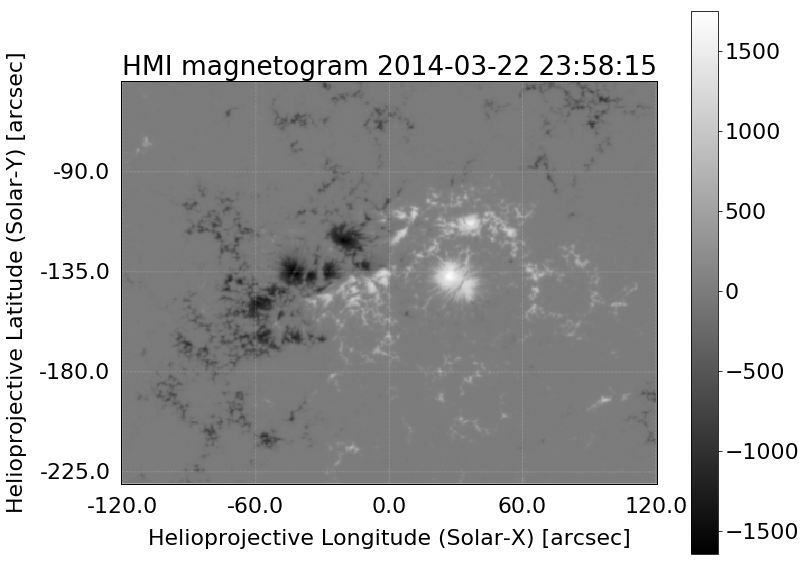

In [3]:
HMIsubmap = data.submap(bl, tr)
HMI_rotated = HMIsubmap.rotate(angle = 180 * u.deg)
HMI_rotated.peek()

Loop over files to find fragments and create text document that represents the properties of fragments in each image file.

0.9166666666666666
0.9333333333333333
0.95
0.9666666666666667
0.9833333333333333
0.0
0.016666666666666666
0.03333333333333333
0.05
0.06666666666666667


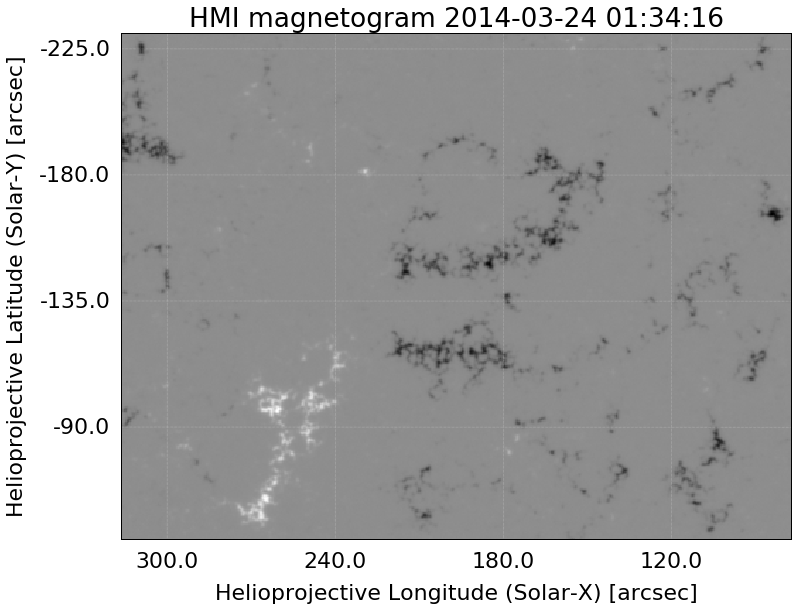

In [36]:
# For each image...
for image in range(len(files_to_load)):
    # Create the full filepath of the FITS file
    filename = datapath + files_to_load[image]

    # Pull out the data into a SunPy map
    data = sunpy.map.Map(filename)
    
    # Transform the initial window coordinates into lat/long coordinates at the time of this image
    # Calculate the timedelta from the original image in days
    timedelta = (data.date - initial_obs_time).total_seconds()/86400
    [bl, tr] = window_corner_rotation(bl_stonyhurst, tr_stonyhurst, timedelta, data.date)    
    
    # Create a submap using those coordinates
    # We are creating two submaps that are identical because from
    # this point on, all positive polarity data will be split from
    # negative polarity data
    pos_submap_area = data.submap(bl, tr)
    neg_submap_area = data.submap(bl, tr)

    # Set all of the edge pixels in the submaps to zero. This stops
    # errors in the 'find_regions' function
    neg_submap_area_data = np.array(neg_submap_area.data)
    neg_submap_area_data = np.pad(neg_submap_area_data, ((1, 1), (1, 1)), 'constant', constant_values=(0, 0))
    pos_submap_area_data = np.array(pos_submap_area.data)
    pos_submap_area_data = np.pad(pos_submap_area_data, ((1, 1), (1, 1)), 'constant', constant_values=(0, 0))
    
    # Strip out all negative data in the positive submap, and vice versa
    pos_submap_data = split_pol_thresh(pos_submap_area_data, threshold, 'pos')
    neg_submap_data = split_pol_thresh(neg_submap_area_data, threshold, 'neg')
      
    # Find the regions in the positive and negative magnetogram data
    pos_region_frame, num_pos_regions = find_regions(pos_submap_data)
    neg_region_frame, num_neg_regions = find_regions(neg_submap_data)

    # Convert the data into label frames that scikit-image can use
    pos_labeled_frame, pos_num_labels = ms.label(pos_region_frame.astype(int),
                                                 return_num=True,
                                                 connectivity=2)
    neg_labeled_frame, neg_num_labels = ms.label(neg_region_frame.astype(int),
                                                 return_num=True,
                                                 connectivity=2)

    # Use the scikit-image method 'regionprops' to get various properties on
    # the fragments in the image data
    pos_properties = ms.regionprops(pos_labeled_frame,
                                    intensity_image=pos_submap_area.data)
    neg_properties = ms.regionprops(neg_labeled_frame,
                                    intensity_image=neg_submap_area.data)
        

    # Write the properties to files. Note that to add new properties,
    # do so in the 'write_props' function
    write_props(pos_properties, 'p', image, data.date, pos_submap_area, bulk_region_props_path)
    write_props(neg_properties, 'n', image, data.date, neg_submap_area, bulk_region_props_path)
    
    pos_submap_area.plot()
    plt.savefig('HMI'+str(image))